# Тестирование

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle
import copy

from torch.utils.data import Dataset, DataLoader
from torch import nn

from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from typing import Dict, Any, Tuple, List, Union, Sequence, Callable

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")


from utils.estimation import (plot_aa_metrics, rejection_curves_procedure, 
                              build_basic_dict_curve, build_custom_dict_curve,
                             draw_rejection_curves)
from utils.attacks import ifgsm_procedure

In [24]:
col = 'FordA'

import sktime
from sktime.datasets import load_from_tsfile

x_train, y_train = load_from_tsfile("data/Ford_A/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile("data/Ford_A/FordA_TEST.ts")

In [25]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(array([-1,  1]), array([1846, 1755]))
(array([-1,  1]), array([681, 639]))


((3601, 500), (1320, 500), (3601,), (1320,))

In [26]:
def transform_X(X):
    np_data = []
    lens = []
    for i in range(len(X)):
        line = X.iloc[i, 0]
        lens.append(len(line))
        np_data.append(line)
        
    #print(np.mean(lens), np.std(lens))
    return np.array(np_data)

(36010, 50) (13200, 50) (36010, 1) (13200, 1)


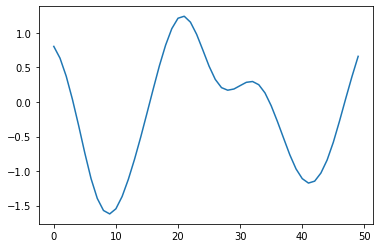

In [27]:
window = 50
len_seq = x_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([x_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([x_test[:, i:i+window] for i in range(n_patches)])

y_train = np.array([(int(y)+1) // 2 for y in y_train])
y_test = np.array([(int(y)+1) // 2 for y in y_test])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)])
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.plot(X_train[1])

In [28]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

## modelling

In [29]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        
#         start_ind = np.random.randint(0, len(X) - self.window)
#         X = X[start_ind:start_ind+self.window]
        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

    
BS = 64    
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=BS, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=BS, shuffle=False)

In [30]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output


In [35]:
def train_step(model, loader, criterion, device, optimizer, scheduler=None):
    losses, n_batches = 0, 0
    model.train(True)
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.reshape(-1, 1).to(device)
        
        y_out = model(x)
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1

    mean_loss = losses / n_batches

    if scheduler:
        scheduler.step()
    
    return mean_loss

def valid_step(model, loader, criterion, device):
    
    losses, n_batches = 0, 0
    model.eval()    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            labels = labels.reshape(-1, 1).to(device)

            y_out = model(x)
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1

    mean_loss = losses / n_batches
    return mean_loss


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1
    
def estimate_epoch(loader, model=None, device='cpu', round_=True, multiclass=False):
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])
    
    for X, y_true in loader:
        X = X.to(device)
        y_pred = model(X)
        
        if multiclass:
            y_pred = torch.argmax(y_pred, axis=1)
        else:
            y_pred = torch.round(y_pred)
        
        y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
        y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    acc, pr, rec, f1 = calculate_metrics(y_all_true, y_all_pred)
    
    return acc, pr, rec, f1

def train_procedure(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 

        acc_train, pr_train, rec_train, f1_train = estimate_epoch(train_loader, model, device=device)
        acc_test, pr_test, rec_test, f1_test = estimate_epoch(test_loader, model, device=device)

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
            #plt.hist(y_test_pred)
            plt.show()
            
    return model


In [36]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = X_train_tensor.reshape([X_train_tensor.shape[0],X_train_tensor.shape[1], 1])
X_test_tensor = X_test_tensor.reshape([X_test_tensor.shape[0],X_test_tensor.shape[1], 1])

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

In [37]:
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1

def plotting(y_true, y_pred, window=1000):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true[-window:], label = 'True')
    plt.plot(y_pred[-window:], label = 'Pred')
    plt.grid()
    plt.legend()
    plt.show()

## Stop here

In [38]:
model_id = 0
torch.manual_seed(model_id)

In [13]:
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 30
print(num_epochs)
LR = 0.001

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

model

30


LSTM_net(
  (rnn): LSTM(1, 50, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [14]:
# model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
#                 num_epochs=15, step_print=5)

#torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{RS}_{col}.pth'

In [39]:
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 15
#print(num_epochs)
LR = 0.001

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3

for model_id in range(5, 10):
    print(model_id)
    torch.manual_seed(model_id)

    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)
    
    model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=15, step_print=5)
    
    torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}.pth') 

5


  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.513; f1_train 0.002; test loss: 0.693; acc_test 0.517; f1_test 0.003;
[Epoch 6] train loss: 0.622; acc_train 0.648; f1_train 0.723; test loss: 0.596; acc_test 0.656; f1_test 0.728;
[Epoch 11] train loss: 0.460; acc_train 0.786; f1_train 0.776; test loss: 0.476; acc_test 0.764; f1_test 0.755;
6


  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.513; f1_train 0.000; test loss: 0.692; acc_test 0.516; f1_test 0.001;
[Epoch 6] train loss: 0.583; acc_train 0.687; f1_train 0.741; test loss: 0.572; acc_test 0.677; f1_test 0.733;
[Epoch 11] train loss: 0.454; acc_train 0.782; f1_train 0.756; test loss: 0.486; acc_test 0.756; f1_test 0.726;
7


  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.499; f1_train 0.512; test loss: 0.693; acc_test 0.508; f1_test 0.523;
[Epoch 6] train loss: 0.670; acc_train 0.638; f1_train 0.676; test loss: 0.620; acc_test 0.634; f1_test 0.673;
[Epoch 11] train loss: 0.466; acc_train 0.783; f1_train 0.771; test loss: 0.482; acc_test 0.754; f1_test 0.740;
8


  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.513; f1_train 0.000; test loss: 0.693; acc_test 0.516; f1_test 0.000;
[Epoch 6] train loss: 0.561; acc_train 0.693; f1_train 0.689; test loss: 0.539; acc_test 0.699; f1_test 0.698;
[Epoch 11] train loss: 0.448; acc_train 0.790; f1_train 0.774; test loss: 0.473; acc_test 0.758; f1_test 0.739;
9


  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.513; f1_train 0.000; test loss: 0.692; acc_test 0.516; f1_test 0.000;
[Epoch 6] train loss: 0.550; acc_train 0.719; f1_train 0.691; test loss: 0.524; acc_test 0.720; f1_test 0.691;
[Epoch 11] train loss: 0.442; acc_train 0.788; f1_train 0.761; test loss: 0.477; acc_test 0.761; f1_test 0.730;


In [16]:
# for epoch in tqdm(range(num_epochs)):

#     train_loss = train_step(train_loader, model)
#     test_loss = valid_step(test_loader, model) 
    
#     X_test_tensor_loc = X_test_tensor #.reshape([X_test_tensor.shape[0], 1, X_test_tensor.shape[1]])
#     X_train_tensor_loc = X_train_tensor #.reshape([X_train_tensor.shape[0], 1, X_train_tensor.shape[1]])
    
#     y_test_pred = all_predict_training(X_test_tensor_loc.to(device), model).astype('int').reshape(-1)
#     y_train_pred = all_predict_training(X_train_tensor_loc.to(device), model).astype('int').reshape(-1)
       
#     acc_train, pr_train, rec_train, f1_train = calculate_metrics(y_train, y_train_pred)
#     acc_test, pr_test, rec_test, f1_test = calculate_metrics(y_test, y_test_pred)
    
#     if epoch % 5 == 0:
#         #print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; test loss: {test_loss:.3f};')
#         print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
#         plt.hist(y_test_pred)
#         plt.show()
        
#     torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{RS}_{col}.pth')

    

## attacks

In [18]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output

In [19]:
n_iters = 50
eps_params = (1e-3, 1e0, 5)
criterion = torch.nn.BCELoss()
batch_size = BS
n_objects = y_test.shape[0]

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

for model_id in range(1):
    
    path_to_saves = 'checkpoints/Ford_A/'

    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    model_path = path_to_saves + f'model_{0}_{col}.pth'
    model.load_state_dict(copy.deepcopy(torch.load(model_path)))

    aa_res_df, rej_curves_dict = ifgsm_procedure(model=model, loader=test_loader, criterion=criterion, eps_params=eps_params,
                                                 n_steps=n_iters, n_objects=n_objects, train_mode=train_mode)

#     aa_res_df.to_csv(f'results/Ford_A/aa_res_Ford_A_{model_id}.csv')
#     with open(f'results/Ford_A/rej_curves_dict_Ford_A_model_{model_id}.pickle', 'wb') as file:
#         pickle.dump(rej_curves_dict, file)

  0%|          | 0/5 [00:00<?, ?it/s]

*****************  EPS=0.001  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.005623413251903491  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.03162277660168379  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.1778279410038923  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=1.0  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

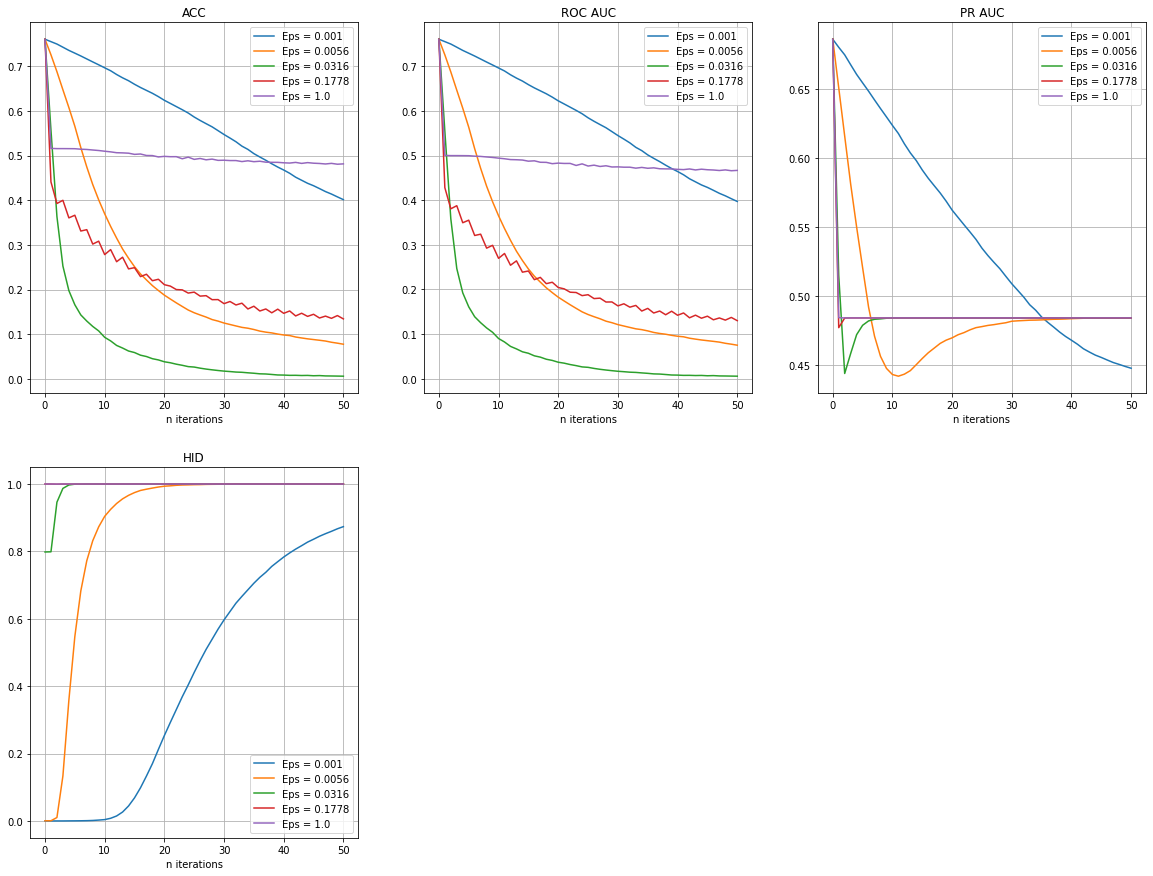

In [10]:
aa_res_df= pd.read_csv(f'results/Ford_A/Original/aa_res_Ford_A_0_alpha=0.1.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric')

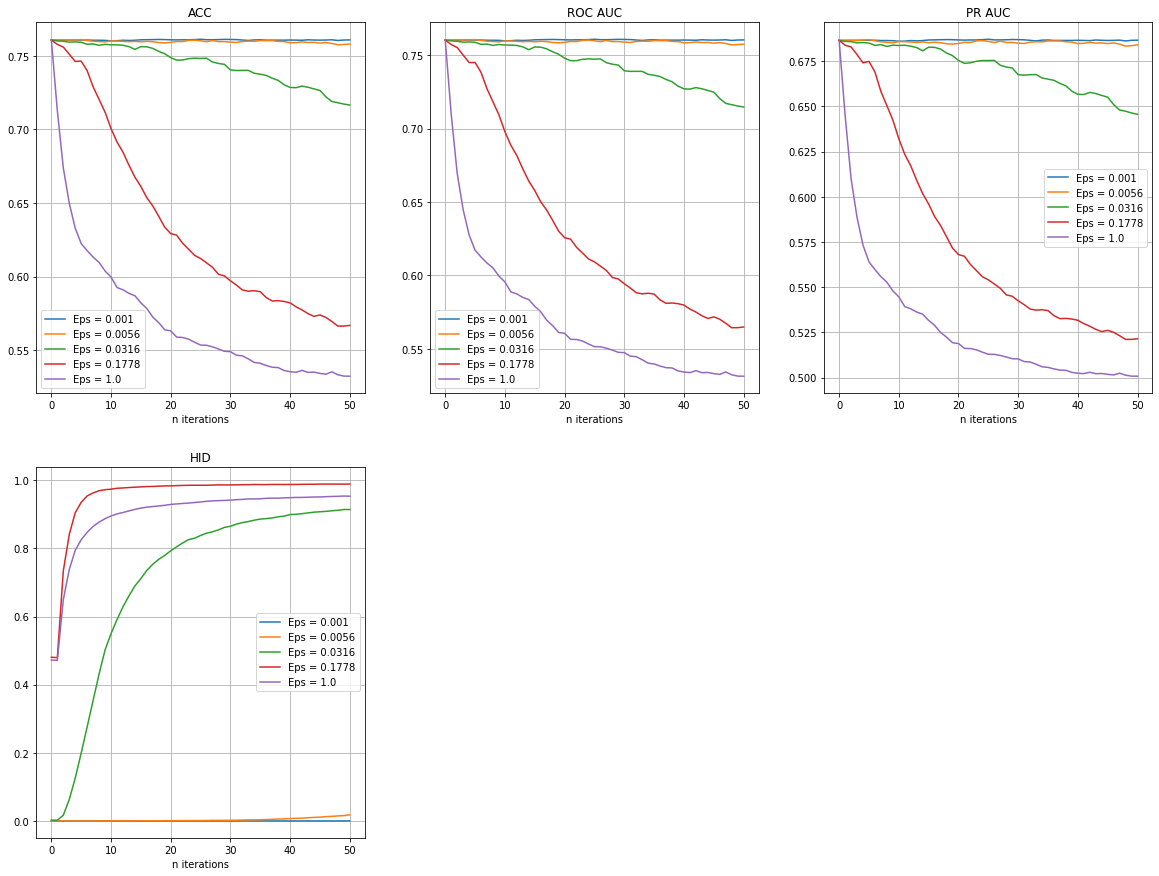

In [2]:
aa_res_df= pd.read_csv(f'results/Ford_A/SimBA/Original/TEST_aa_res_Ford_A_0.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric')

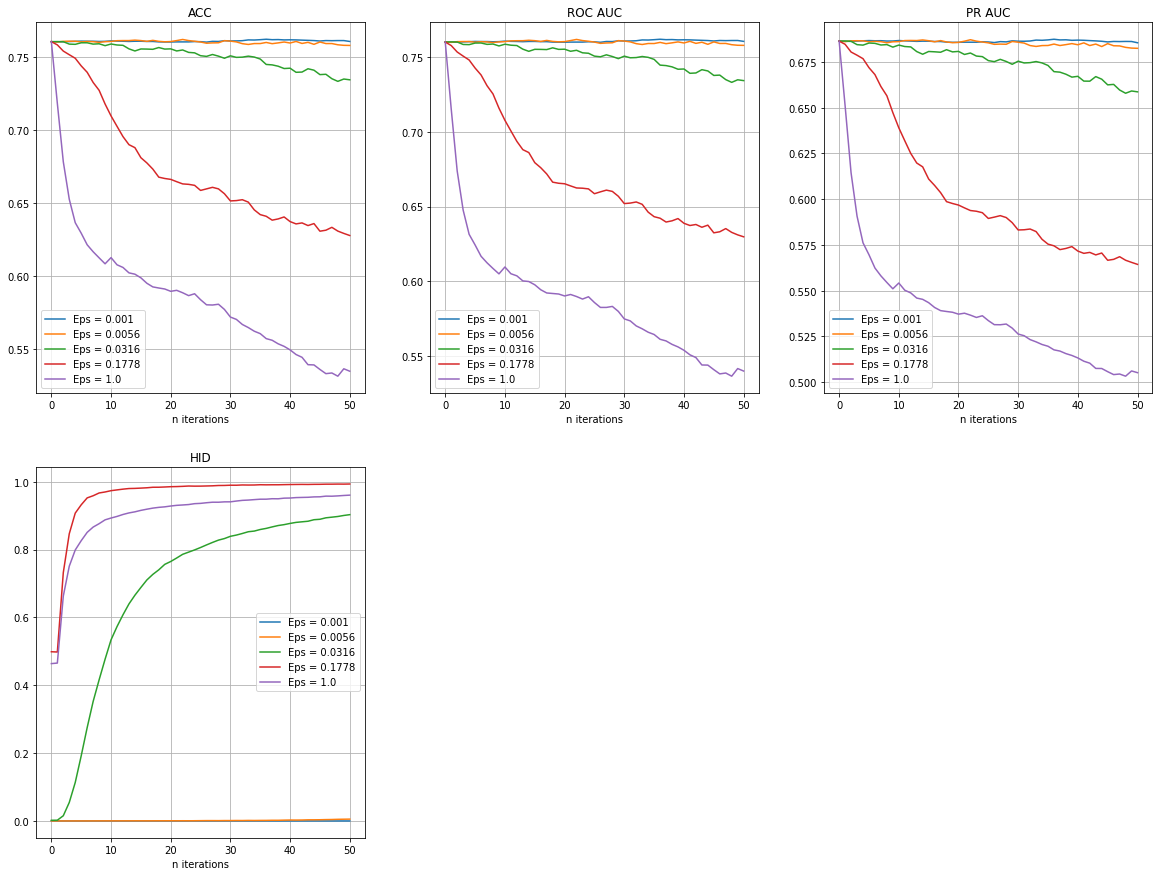

In [8]:
aa_res_df= pd.read_csv(f'results/Ford_A/SimBA/Regular/aa_res_Ford_A_0_alpha=0.1.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric')

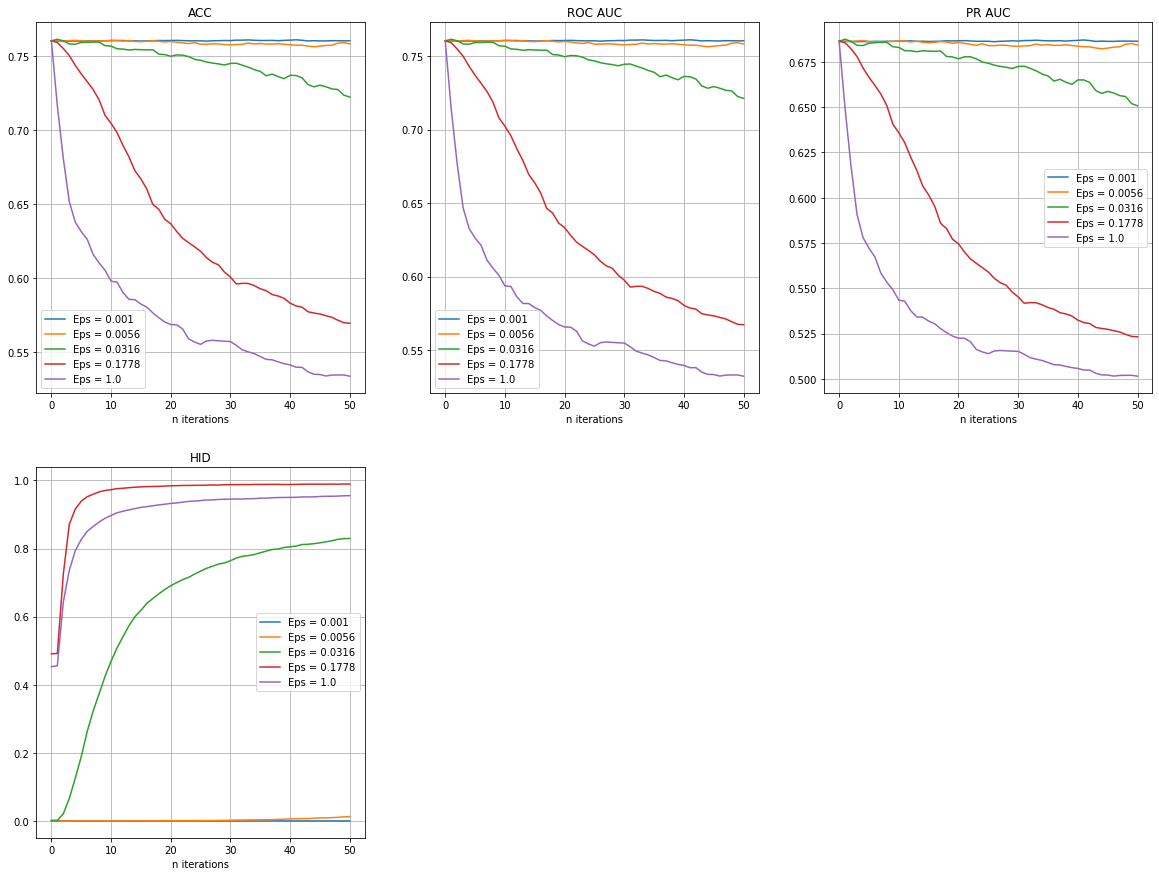

In [3]:
aa_res_df= pd.read_csv(f'results/Ford_A/SimBA/Regular_Disc/aa_res_Ford_A_0_alpha=0.1.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric')

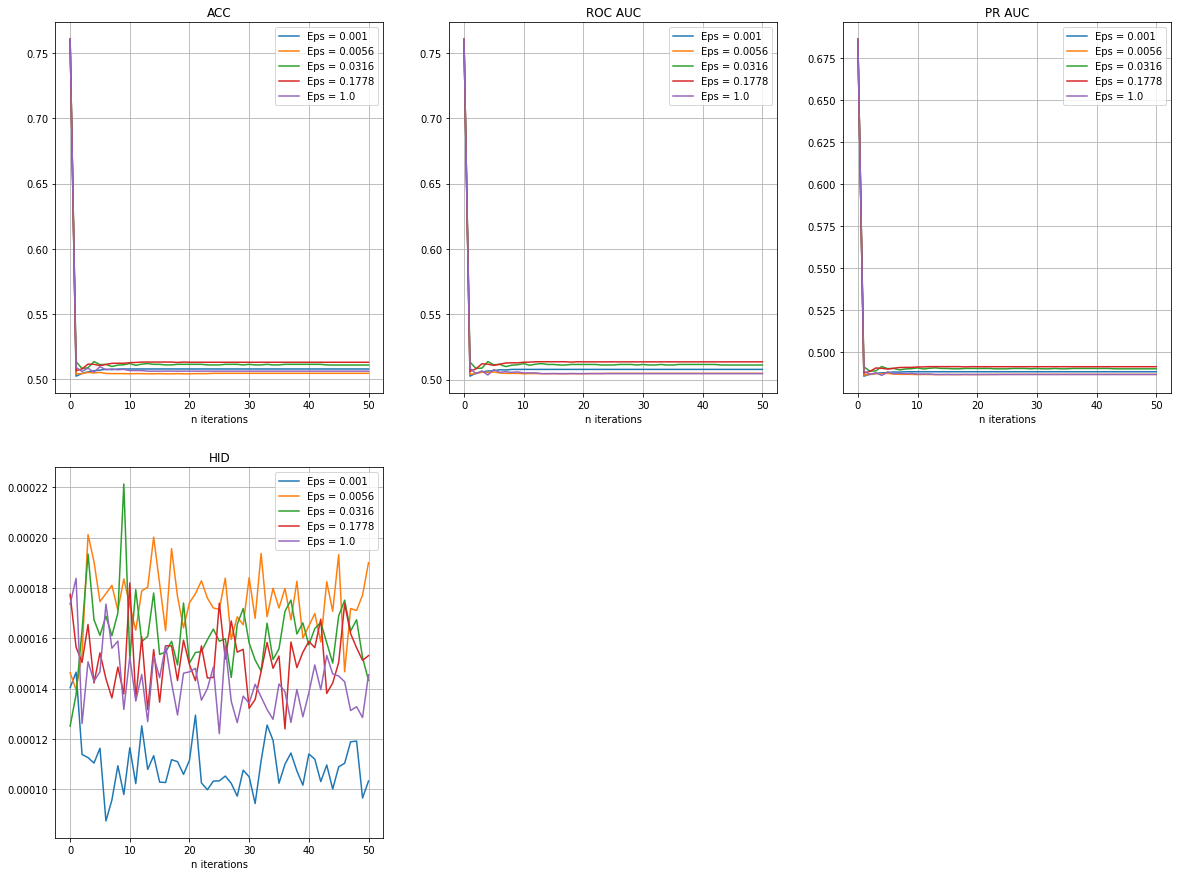

In [8]:
plot_aa_metrics(aa_res_df, method='metric')

In [ ]:
def load_LSTM(model, model_path):
    model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    return model


device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCELoss()



model_params = {"hidden_dim":50,
                "output_dim":1,
                "n_layers":1,
                "dropout":0.0,
                }
model = LSTM_net(**model_params).to(device)


basic_path = 'checkpoints/Ford_A/model_{}_{}.pth'
load_path = [basic_path.format(i, col) for i in range(5)]


preds, norms = rejection_curves_procedure(model, test_loader,
                               criterion, load_LSTM, load_path, y_test, device,
                               n_models=5)

In [ ]:
model_id = 0

with open(f'results/Ford_A/rej_curves_dict_Ford_A_model_{model_id}.pickle', 'rb') as file:
    rej_curves_dict = pickle.load(file)


rejection_rates = np.linspace(0, 1.0, 20)
iter_to_break = 49
dict_metrics = {'Acc':accuracy_score,
               #'ROC AUC':roc_auc_score,
               #'PR AUC':average_precision_score
               }

all_eps = list(rej_curves_dict.keys())


dict_curves = build_basic_dict_curve(y_test, preds, norms, rejection_rates, dict_metrics)
dict_curves = build_custom_dict_curve(dict_curves, y_test, preds, norms, rejection_rates, 
                                     dict_metrics, rej_curves_dict, all_eps, iter_to_break)

draw_rejection_curves(dict_curves, rejection_rates)

In [ ]:
df_ROC_RC = pd.DataFrame(columns=['metric', 'method', 'value'])

for metric_name, dict_curve_metric in dict_curves.items():
    
    for method_name, list_val in dict_curve_metric.items():
        val = np.array(list_val)
        val_start = val[:-1]
        val_post = val[1:]

        val_mean = np.sum(np.array([val_start, val_post]))/(2*(len(rejection_rates)-1))
        
        dict_res = dict(zip(df_ROC_RC.columns,[metric_name, method_name, val_mean]))
        df_ROC_RC = df_ROC_RC.append(dict_res, ignore_index=True)
        
df_ROC_RC

# Получение адверсальных данных

In [ ]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

def prepare_adv_data(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        eps: float,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = torch.tensor([]) # logging y_true for rebuilding dataloader and calculation difference with preds
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)

        y_pred = model(x)

        # attack for adv input
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
        x_adv = x.data + eps * torch.sign(grad_)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

    return x_adv_tensor.detach(), all_y_true.detach()

In [ ]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

In [ ]:
X_adv.shape, y_adv.shape

In [ ]:
eps = 1
criterion = torch.nn.BCELoss()
batch_size = 256
n_objects = y_train.shape[0]
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

num_epochs = 30

for model_id in tqdm(range(1, 5)):
    
    path_to_saves = 'checkpoints/Ford_A/'

    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    model_path = path_to_saves + f'model_{model_id}_{col}.pth'
    model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    
    # attack data    
    X_adv, y_adv = prepare_adv_data(model, train_loader, criterion, eps, device, train_mode=train_mode)
            
    #rebuild dataset and dataloader
    new_x_train, new_y_train = torch.concat([X_train_tensor, X_adv], dim=0), torch.concat([y_train_tensor, y_adv], dim=0)
    train_adv_loader = DataLoader(MyDataset(new_x_train, new_y_train), batch_size=BS, shuffle=True)

    
    #train model on attacked data
    torch.manual_seed(model_id)
    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

    model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=15, step_print=3)
    #save model
    torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}_adv.pth') 
    

In [ ]:
from utils.TS2Vec import datautils

datautils.load_UCR('Coffee')[0].shape

# Documentation

In [ ]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torch import nn

# from typing import Dict, Any, Tuple, List, Union, Sequence, Callable

# Attacks

In [ ]:
# def calculate_metrics_class(y_true, y_pred):
#     acc = accuracy_score(y_true, y_pred)
#     roc = roc_auc_score(y_true, y_pred)
#     pr = average_precision_score(y_true, y_pred)
#     return acc, roc, pr

# def calc_accuracy(y_true, y_pred, y_pred_adv):
#     acc_val = np.mean((y_pred == y_true))
#     acc_adv = np.mean((y_pred_adv == y_true)) 
#     return acc_val, acc_adv

# def req_grad(model: nn.Module, state: bool = True) -> None:
#     """Set requires_grad of all model parameters to the desired value.

#     :param model: the model
#     :param state: desired value for requires_grad
#     """
#     for param in model.parameters():
#         param.requires_grad_(state)

In [ ]:
# def build_df_aa_metrics(metric_dict, eps):
    
#     results_df = pd.DataFrame.from_dict(metric_dict, orient="index")
#     results_df.set_axis(
#         pd.Index(["ACC", "ROC AUC", "PR AUC"], name="metric"), axis=1, inplace=True
#     )
#     results_df.set_axis(
#         pd.Index(results_df.index, name="n steps",), axis=0, inplace=True,
#     )

#     results_df = results_df.reset_index()
#     results_df['eps'] = eps
#     return results_df

# def ifgsm_one_iter(
#     model: nn.Module, #model for attack
#     loader: DataLoader, #dataloader with data
#     criterion: nn.Module,
#     eps: float,
#     train_mode=False): #params_dict with eps and iter number

#     model.train(train_mode)
#     req_grad(model, state=False)  # detach all model's parameters

#     all_y_true = [] #logging y_true for rebuilding dataloader and calculation difference with preds
#     all_preds = [] #logging predictions original for calculation difference with data
#     all_preds_adv = [] #logging predictions for calculation difference with data
#     x_adv_tensor = torch.FloatTensor([]) #logging x_adv for rebuilding dataloader
    

#     for x, y_true in loader:

#         all_y_true.extend(y_true.detach().data.numpy())
        
#         x.grad = None
#         x.requires_grad = True
        
#         # prediction for original input
#         x = x.to(device, non_blocking=True)
#         y_true = y_true.to(device)
        
#         y_pred = model(x) 
           
#         # attack for adv input
#         loss_val = criterion(y_pred, y_true.reshape(-1, 1))        
#         grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
#         x_adv = x.data + eps * torch.sign(grad_)
#         x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)
        
#         #assert (x_adv == x).sum() == 0, "Data doesn't change after attack"
        
#         #class prediction
#         preds = torch.argmax(y_pred, dim=1).clone().cpu().detach()
#         all_preds.extend(y_pred.cpu().detach().data.numpy())
        
#         # prediction for adv input
#         with torch.no_grad():
#             y_pred_adv = model(x_adv)
#             preds_adv = torch.argmax(y_pred_adv, dim=1).clone().cpu().detach() #class prediction
#             all_preds_adv.extend(y_pred_adv.cpu().detach().data.numpy())
        
#         #assert (y_pred_adv == y_pred).sum() == 0, "Predicitions doesn't change after attack"
    
#     return x_adv_tensor, all_y_true, all_preds, all_preds_adv
    

    
# def ifgsm_iterations(model: nn.Module,
#                      loader: DataLoader,
#                      dataset: Dataset,
#                      criterion: nn.Module,
#                      eps: float,
#                      n_steps: int,
#                      metric_fun,
#                      batch_size = 8,
#                      n_objects=100,
#                      multiclass=False,
#                      train_mode=False,
#                     ):
    
#     aa_res_dict = dict()    
    
#     rejection_dict = dict()
#     rejection_dict['diff'] = dict()
#     iter_broken_objs = np.array([10**7]*n_objects)
    
#     for iter_ in tqdm(range(n_steps)):
        
#         #attack
#         x_adv_tensor, y_true, preds_original, preds_adv = ifgsm_one_iter(model, loader, criterion, 
#                                                                          eps, train_mode=train_mode) 
        
#         if multiclass:
#             preds_flat_round = np.argmax(np.array(preds_original), axis=1).flatten()
#             preds_adv_flat_round = np.argmax(np.array(preds_adv), axis=1).flatten()
#             y_true_flat =  np.array(y_true).flatten()
#             shape_diff = (1, 2)
            
#         else:
#             preds_flat_round = np.round_(np.array(preds_original)).flatten()
#             preds_adv_flat_round = np.round_(np.array(preds_adv)).flatten()
#             y_true_flat =  np.array(y_true).flatten()
#             shape_diff = (1)
            
#         #estimation        
#         if iter_ == 0:
#             iter_broken_objs[preds_flat_round != y_true_flat] = iter_
#             aa_res_dict[iter_] = metric_fun(y_true_flat, preds_flat_round)
#             preds_iter_1 = np.array(preds_original)         
            
#         iter_broken_objs[(preds_adv_flat_round != y_true_flat) & (iter_broken_objs > iter_)] = iter_+1
        
#         rejection_dict['diff'][iter_+1] = np.sum((preds_iter_1 - np.array(preds_adv))**2, axis=shape_diff)
        
        
#         rejection_dict['iter_broke'] = iter_broken_objs
#         aa_res_dict[iter_+1] = metric_fun(y_true_flat, preds_flat_round)

#         # rebuilding dataloader for new iteration
#         it_dataset = dataset(x_adv_tensor, torch.tensor(y_true)) 
#         loader=DataLoader(it_dataset, batch_size=batch_size)
        
#     return aa_res_dict, rejection_dict

# def ifgsm_procedure(model: nn.Module,
#                     loader: DataLoader,
#                     dataset: Dataset,
#                     criterion: nn.Module,
#                     eps_params: Tuple[float, float, int],
#                     n_steps: int,
#                     metric_fun,
#                     batch_size = 8,
#                     n_objects=100,
#                     train_mode=False,
#                    ):
#     aa_res_df = pd.DataFrame()  
    
#     rej_curves_dict = dict() # multilevel dict  eps -> diff and object 
#     # diff -> #n_iteration -> np.array difference between original prediction without attack and broken predictions
#     # object -> np.array n_iter when wrong prediction
    
#     eps_for_check = np.geomspace(*eps_params)
    
#     for eps in tqdm(eps_for_check):
#         print(f'*****************  EPS={eps}  ****************')

#         aa_res_iter_dict, rej_curves_iter_dict = ifgsm_iterations(model, loader, dataset, criterion, eps,  
#                                                                   n_steps, metric_fun, batch_size, n_objects, 
#                                                                   train_mode=train_mode)

#         rej_curves_dict[eps] = rej_curves_iter_dict
#         aa_res_df = pd.concat([aa_res_df, build_df_aa_metrics(aa_res_iter_dict, eps)])
        
#     return aa_res_df, rej_curves_dict


In [ ]:
# n_iters = 50
# #eps_params = (1e-2, 1e0, 10)
# eps_params = (0.3, 1e0, 1)
# eps_params = (1e-3, 1e0, 5)
# criterion = torch.nn.CrossEntropyLoss()

# aa_res_df, rej_curves_dict = ifgsm_procedure(model=model, dataloader=test_loader, criterion=criterion, 
#                                              eps_params=eps_params, n_steps=n_iters, 
#                                              metric_fun=calculate_metrics_class, batch_size=batch_size)

# aa_res_df.to_csv(f'results/aa_res_{col}.csv')
# with open(f'results/rej_curves_dict_{col}.pickle', 'wb') as file:
#     pickle.dump(result_broket_dict, file)

# Visualisation AA res

In [ ]:
# def plot_aa_metrics(res_df, method='eps'):
    
#     metrics = ["ACC", "ROC AUC", "PR AUC"]    
#     if method=='eps':
#         plt.figure(figsize=(15, 12))

#         for i, eps in enumerate(res_df['eps'].unique()):    
#             plt.subplot(2, 3, i+1)
            
#             for metric in metrics:
#                 df_loc = res_df[res_df['eps'] == eps].copy()
#                 plt.plot(df_loc.index, df_loc[metric], label=metric)
#             plt.title(f'Eps = {round(eps, 4)}')
#             plt.xlabel('n iterations')
#             plt.legend()
#             plt.grid()

#     elif method=='metric':
#         plt.figure(figsize=(20, 15))
        
#         for i, metric in enumerate(metrics):
#             plt.subplot(2, 3, i+1)
            
#             for eps in res_df['eps'].unique():
#                 df_loc = res_df[res_df['eps'] == eps].copy()
#                 plt.plot(df_loc.index, df_loc[metric],  label=f'Eps = {round(eps, 4)}')
#             plt.title(metric)
#             plt.xlabel('n iterations')
#             plt.legend()
#             plt.grid()
        
#     else:
#         raise ValueError('metho should be eps or metric')
        

#     plt.show()

# Rejection curves

In [ ]:
# def get_ensemble_mi(preds:  np.ndarray) -> np.ndarray:
#     """Calculate entropy of a given 1d numpy array. Input values are clipped to [0, 1].

#     :param p: numpy array of numerics
#     :return: numpy array of entropy values
#     """
#     _, pentropy = get_ensemble_predictive_entropy(preds)
#     ave_preds, eentropy = get_ensemble_expected_entropy(preds)

#     return ave_preds, (pentropy - eentropy)

# def get_minprob(pred: np.ndarray) -> np.ndarray:
#     """Calculate minprob uncertainty estimate. Input values are clipped to [0, 1].
#     :param pred: numpy array of numerics
#     :return: numpy array of minprob estimates
#     """

#     def func(pred):
#         if pred < 0.5:
#             return pred, pred
#         else:
#             return pred, (1 - pred)

#     func_vec = np.vectorize(func)
#     clipped_pred = np.clip(pred, 1e-5, 1 - 1e-5)

#     return func_vec(clipped_pred)

# def get_entropy(p: np.ndarray) -> np.ndarray:
#     """Calculate entropy of a given 1d numpy array. Input values are clipped to [0, 1].

#     :param p: numpy array of numerics
#     :return: numpy array of entropy values
#     """
#     cp = np.clip(p, 1e-5, 1 - 1e-5)
#     entropy = -cp * np.log2(cp) - (1 - cp) * np.log2(1 - cp)

#     return entropy



# def get_ensemble_predictive_entropy(preds: np.ndarray) -> np.ndarray:
#     """Calculate predictive entropy of ensemble predictions.
#     :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
#     :return: numpy array of predictive entropy estimates
#     """
#     ave_preds = np.average(np.copy(preds), axis=0)

#     return ave_preds, get_entropy(ave_preds)


# def get_ensemble_expected_entropy(preds: np.ndarray) -> np.ndarray:
#     """Calculate expected entropy of ensemble predictions.
#     :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
#     :return: numpy array of predictive entropy estimates
#     """
#     ave_preds = np.average(np.copy(preds), axis=0)

#     return ave_preds, np.apply_along_axis(get_entropy, 0, preds).mean(axis=0)


# def get_ensemble_std(preds: np.ndarray) -> np.ndarray:
#     """Calculate estimate of standard deviation of ensemble predictions.
#     :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
#     :return: numpy array of standard deviation estimates estimates
#     """
#     ave_preds = np.average(np.copy(preds), axis=0)

#     return ave_preds, np.std(preds, axis=0)


# def sort_data_by_metric(
#     metric: Sequence, preds: np.ndarray, labels: np.ndarray
# ) -> Tuple[List, List]:
#     """Sort preds and labels by descending uncertainty metric.
#     :param metric: uncertainty metric according to which preds and labels will be sorted
#     :param preds: model predictions
#     :param labels: ground truth labels
#     :return: a tuple of
#         - np.ndarray of predictions, sorted according to metric
#         - np.ndarray of labels, sorted according to metric
#     """
#     sorted_metric_idx = np.argsort(metric)

#     return preds[sorted_metric_idx].flatten(), labels[sorted_metric_idx].flatten()


# def get_upper_bound_idx(data_len: int, rejection_rates: Sequence[float]) -> List[float]:
#     """Calculate upped bounds on indices of data arrays.
#     Based on corresponding list of rejection rates is applied.
#     :param data_len: length of data array
#     :param rejection_rates: array of rejection rates to calculate upper bounds for
#     :return: list of upper bounds
#     """
#     idx = []
#     for rate in rejection_rates:
#         idx.append(
#             min(np.ceil(data_len * (1 - rate)), np.array(data_len)).astype(int).item()
#         )

#     return idx


# def reject_and_eval(
#     preds: np.ndarray,
#     labels: np.ndarray,
#     upper_bounds: Sequence[float],
#     scoring_func: Callable,
# ) -> List:
#     """Clip preds and labels arrays.
#     Using list of upper bounds, and calculate scoring metric for
#     predictions after rejection.
#     :param preds: model label predictions or predicted class probabilities
#     :param labels: ground truth labels
#     :param upper_bounds: list of upper bounds to clip preds and labels to
#     :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
#     :return: list of scores calculated for each upper bound
#     """
#     scores = []
#     predicted_labels = np.where(preds > 0.5, 1, 0)
    
    
#     i = 0
#     for upper_bound in upper_bounds:
#         predicted_labels_below_thresh = predicted_labels[0:upper_bound]
#         preds_below_thresh = preds[0:upper_bound]
#         labels_below_thresh = labels[0:upper_bound]

#         try:
#             if preds_below_thresh.size > 0 and labels_below_thresh.mean() not in [0, 1]:
#                 scores.append(scoring_func(labels_below_thresh, preds_below_thresh))
                
#         except ValueError:
#             if (
#                 predicted_labels_below_thresh.size > 0
#                 and labels_below_thresh.mean() not in [0, 1]
#             ):
#                 scores.append(
#                     scoring_func(labels_below_thresh, predicted_labels_below_thresh)
#                 )
#         i += 1
    
#     #print(scores)
#     return scores


# def reject_by_metric(
#     get_metric: Callable,
#     preds: np.ndarray,
#     labels: np.ndarray,
#     rejection_rates: List[float],
#     scoring_func: Callable,
# ) -> List:
#     """Reject points from preds and labels based on uncertainty estimate of choice.
#     :param get_metric: function that returns uncertainty metric for given model predictions
#     :param preds: model label predictions or predicted class probabilities
#     :param labels: ground truth labels
#     :param rejection_rates: list of rejection rates to use
#     :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
#     :return: list of scores calculated for each upper bound
#     """
    
#     #print(scoring_func)

#     preds, metric_values = get_metric(preds)
    
#     preds_sorted, labels_sorted = sort_data_by_metric(metric_values, preds, labels)
#     #print(preds_sorted.shape, labels_sorted.shape)
    
#     upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
    
#     res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
#     return res

In [ ]:
# def reject_by_iters_obj(
#     iters_vec: np.ndarray,
#     preds: np.ndarray,
#     labels: np.ndarray,
#     rejection_rates: List[float],
#     scoring_func: Callable,
# ) -> List:
    
#     preds = np.average(np.copy(preds), axis=0)
#     preds_sorted, labels_sorted = sort_data_by_metric(1/(iters_vec+0.001), preds, labels)
#     #preds_sorted, labels_sorted = sort_data_by_metric(iters_vec, preds, labels)
    
#     upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
#     res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
#     return res

# def reject_by_diff(
#     diff_vec: np.ndarray,
#     preds: np.ndarray,
#     labels: np.ndarray,
#     rejection_rates: List[float],
#     scoring_func: Callable,
# ) -> List:
    
#     preds = np.average(np.copy(preds), axis=0)
    
#     preds_sorted, labels_sorted = sort_data_by_metric(1/(diff_vec+0.001), preds, labels)
#     #preds_sorted, labels_sorted = sort_data_by_metric(diff_vec, preds, labels)
    
#     upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
#     res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
#     return res

# def reject_by_norm(
#     norm_vec: np.ndarray,
#     preds: np.ndarray,
#     labels: np.ndarray,
#     rejection_rates: List[float],
#     scoring_func: Callable,
# ) -> List:
    
#     preds = np.average(np.copy(preds), axis=0)

#     #print(len(iters_vec), len(preds), len(labels))
#     #preds_sorted, labels_sorted = sort_data_by_metric(1/(norm_vec+1), preds, labels)
#     preds_sorted, labels_sorted = sort_data_by_metric(norm_vec, preds, labels)
    
#     upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
#     res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
#     return res

# def reject_randomly(
#     preds: np.ndarray,
#     labels: np.ndarray,
#     rejection_rates: List[float],
#     num_samples: int,
#     scoring_func: Callable,
# ) -> np.ndarray:
#     """Reject predictions after random shuffling.

#     Perform sampling num_samples times for each rejection rate and average over them

#     :param preds: model label predictions or predicted class probabilities
#     :param labels: ground truth labels
#     :param rejection_rates: list of rejection rates to use
#     :param num_samples: number of repetitions of shuffling + rejection
#     :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
#     :return: list of scores calculated for each upper bound
#     """
#     accs = []
#     upper_indices = get_upper_bound_idx(preds.size, rejection_rates)

#     for _ in range(num_samples):
#         shuffle_indices = np.random.permutation(preds.size)
#         accs.append(
#             reject_and_eval(
#                 preds[shuffle_indices],
#                 labels[shuffle_indices],
#                 upper_indices,
#                 scoring_func,
#             )
#         )

#     return np.mean(accs, axis=0)

In [ ]:
# def build_basic_dict_curve(
#     labels, 
#     preds:list,
#     norms:np.array,
#     rejection_rates:np.array, 
#     dict_metrics:dict,
#     ):

#     dict_curves = dict()
    
#     preds = np.array(preds)
#     ave_preds = np.average(preds, axis=0)

#     for metric_name, metric in  dict_metrics.items():
        

#         dict_curve_metric = dict()


#         dict_curve_metric['Predictive entropy'] = reject_by_metric(get_ensemble_predictive_entropy,
#                                          preds,
#                                          labels, 
#                                          rejection_rates,
#                                          metric)


#         dict_curve_metric['StD'] = reject_by_metric(get_ensemble_std,
#                                     preds,
#                                     labels, 
#                                     rejection_rates,
#                                     metric)

#         dict_curve_metric['MaxProb'] = reject_by_metric(get_minprob,
#                                         preds[0, :],
#                                         labels, 
#                                         rejection_rates,
#                                         metric)

#         dict_curve_metric['Random'] = reject_randomly(ave_preds,
#                                       labels, 
#                                       rejection_rates,
#                                       1000,
#                                       metric)

#         dict_curve_metric['Grad_Norm'] = reject_by_norm(norms,
#                                     preds,
#                                     labels, 
#                                     rejection_rates,
#                                     metric)
        
        
#         dict_curves[metric_name] = dict_curve_metric
#     return dict_curves


# def build_custom_dict_curve(dict_curves:dict,
#                         labels, 
#                         preds:list,
#                         norms:np.array,
#                         rejection_rates:np.array, 
#                         dict_metrics:dict,
#                         rej_curves_dict:dict, 
#                         all_eps:list,
#                         iter_to_break:int, ):

#     for metric_name, metric in dict_metrics.items():
    

#         dict_curve_metric = dict()
        
#         type_ = 'diff'
#         eps = all_eps[0]
#         iter_ = iter_to_break
#         rej_vec = abs(rej_curves_dict[eps][type_][iter_])
        
#         dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}_iter={iter_}'] = reject_by_diff(rej_vec,
#                                          preds,
#                                          labels, 
#                                          rejection_rates,
#                                          metric)


#         type_ = 'diff'
#         eps = all_eps[2]
#         iter_ = iter_to_break
#         rej_vec = abs(rej_curves_dict[eps][type_][iter_])
#         dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}_iter={iter_}'] = reject_by_diff(rej_vec,
#                                          preds,
#                                          labels, 
#                                          rejection_rates,
#                                          metric)


#         type_ = 'iter_broke'
#         eps = all_eps[4]
#         iter_ = ''
#         dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}'] = reject_by_iters_obj(rej_curves_dict[eps][type_],
#                                          preds,
#                                          labels, 
#                                          rejection_rates,
#                                          metric)
        
#         # Union 2 dicts
#         dict_curves[metric_name] = {**dict_curves[metric_name], **dict_curve_metric}

        
#     return dict_curves
    
# def draw_rejection_curves(dict_curves):
#     plt.figure(figsize=(17, 9))

#     for i, (metric_name, curves_dict) in enumerate(dict_curves.items()):

#         plt.subplot(1, 3, i+1)

#         for label, metric in curves_dict.items():
#             if 'Iter_diff' in label:
#                 plt.plot(rejection_rates[0:len(metric)], metric, 
#                          label=label, linewidth = 3, linestyle='--')
#             elif 'Iter_object' in label:
#                 plt.plot(rejection_rates[0:len(metric)], metric, 
#                          label=label, linewidth = 3, linestyle='-')

#             elif 'Norm' in label:
#                 plt.plot(rejection_rates[0:len(metric)], metric, 
#                          label=label, linewidth = 3, linestyle=':')
#             else:
#                 plt.plot(rejection_rates[0:len(metric)], metric, label=label)
#         plt.title(metric_name)
#         plt.xlabel('Rejection rate')
#         plt.ylabel(metric_name)
#         plt.legend()
#         plt.grid()

#     plt.show()

In [ ]:
# import copy

# def all_predict(model, loader, round_=True, multiclass=False, device='cpu'):
    
#     y_all_pred = torch.FloatTensor([])
    
#     for x, y_true in loader:
            
#         x = x.to(device)
#         y_true = y_true.to(device)
#         y_pred = model(x)
        
#         if round_: 
#             if multiclass:
#                 y_pred = torch.argmax(y_pred, dim=1)
#             else:
#                 y_pred = torch.round_(y_pred)
#         else:
#             if multiclass:
#                 y_pred = torch.nn.functional.softmax(y_pred)
            
            
#         y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
#     if round_:
#         y_all_pred = torch.round(y_all_pred)
#     y_all_pred = y_all_pred.cpu().detach().numpy()
#     y_all_pred = y_all_pred.reshape([-1, 1])
#     return y_all_pred

# def get_grad_norm(model:nn.Module,
#                   loader:DataLoader,
#                   criterion:nn.Module,
#                   ):
#     grad_norm_model = torch.tensor(np.array([]))
    

#     for x, y_true in loader:
        
#         x.grad = None
#         x.requires_grad = True
        
#         x = x.to(device)
#         y_true = y_true.to(device)

#         y_pred = model(x)
#         loss_val = criterion(y_pred, y_true)

#         grad = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
#         grad_norm = torch.linalg.norm(grad, ord=2, dim=(1,2)).cpu().detach()
#         grad_norm_model = torch.cat((grad_norm_model, grad_norm))
        
#     return np.array(grad_norm_model)

# def rejection_curves_procedure(model:nn.Module, 
#                                loader:DataLoader,
#                                criterion:nn.Module,
#                                load_fun, 
#                                load_params,
#                                labels,
#                                device,
#                                n_models=1,
#                               ):
    
#     norms_all = []
#     preds_all = []
    
#     for i, model_path in enumerate(load_path):

#         #loading_weights
        
#         model = load_fun(model=model, model_path=model_path)
#         model = model.to(device)
#         model.eval()

#         #estimate results        
#         preds_round = all_predict(model=model, loader=loader, 
#                               round_=True, device=device)
#         metrics = calculate_metrics_class(labels, preds_round)
#         acc, roc, pr_auc = metrics
#         print(f"{i}th models Accuracy {acc:.3f}, ROC-AUC {roc:.3f}, PR-AUC {pr_auc:.3f}")
        
#         preds = all_predict(model=model, loader=loader, 
#                               round_=False, device=device)
#         preds_all.append(preds)
        
#         model.train()
#         norm = get_grad_norm(model=model, loader=loader, criterion=criterion)
#         norms_all.append(norm)
        
#     preds = np.array(preds_all).reshape(len(preds_all), preds.shape[0])
#     return preds, np.sum(np.array(norms_all), axis=0)
    
    

In [ ]:
# model_params = {"HIDDEN_DIM":50,
#                 "OUTPUT_DIM":1,
#                 "N_LAYERS":1,
#                 "DROPOUT":0.3,
#                 }

# basic_path = 'checkpoint/model_{}_{}.pth'
# load_path = [basic_path.format(i, col) for i in range(5)]

# model = LSTM_net(**model_params).to(device)
# preds, norms = rejection_curves_procedure(model, test_loader,
#                                criterion, load_path, 
#                                n_models=5)

In [ ]:
# model_params = {"HIDDEN_DIM":50,
#                 "OUTPUT_DIM":1,
#                 "N_LAYERS":1,
#                 "DROPOUT":0.3,
#                 }

# basic_path = 'checkpoint/model_{}_{}.pth'
# load_path = [basic_path.format(i, col) for i in range(5)]
# preds, norms = rejection_curves_procedure(model, loader,
#                                criterion, load_path, 
#                                n_models=5, model_params)

# rejection_rates = np.linspace(0, 1.0, 20)
# iter_to_break = 49
# dict_metrics = {'Acc':accuracy_score,
#                'ROC AUC':roc_auc_score,
#                'PR AUC':average_precision_score}

# all_eps = list(result_broket_dict.keys())


# dict_curves = build_basic_dict_curve(y_test, preds, norms, rejection_rates, dict_metrics)
# dict_curves = build_basic_dict_curve(dict_curves, y_test, preds, norms, rejection_rates, 
#                                      dict_metrics, rej_curves_dict, all_eps, iter_to_break)


# dict_curves[metric_name] = dict_curve_metric
# draw_rejection_curves(dict_curves)

In [ ]:
# draw_rejection_curves(dict_curves)